### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 2. Load Data

In [4]:

df = pd.read_csv('data/Mall_Customers.csv')
print(f"\nDataset loaded: {df.shape}")
print(f"Features: {df.columns.tolist()}")



Dataset loaded: (200, 5)
Features: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


### Feature Engineering

In [5]:
# Select features for clustering (Income and Spending Score as per task)
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].copy()
print(f"\nFeatures selected for clustering:")
print(f"  - Annual Income (k$)")
print(f"  - Spending Score (1-100)")
print(f"\nBefore scaling:")
print(X.describe())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=['Income_Scaled', 'Spending_Scaled'])

print(f"\nAfter scaling:")
print(X_scaled_df.describe())


Features selected for clustering:
  - Annual Income (k$)
  - Spending Score (1-100)

Before scaling:
       Annual Income (k$)  Spending Score (1-100)
count          200.000000              200.000000
mean            60.560000               50.200000
std             26.264721               25.823522
min             15.000000                1.000000
25%             41.500000               34.750000
50%             61.500000               50.000000
75%             78.000000               73.000000
max            137.000000               99.000000

After scaling:
       Income_Scaled  Spending_Scaled
count   2.000000e+02     2.000000e+02
mean   -2.131628e-16    -1.465494e-16
std     1.002509e+00     1.002509e+00
min    -1.738999e+00    -1.910021e+00
25%    -7.275093e-01    -5.997931e-01
50%     3.587926e-02    -7.764312e-03
75%     6.656748e-01     8.851316e-01
max     2.917671e+00     1.894492e+00


### 4. Detecting Optimal Number Of Clusters


Evaluating different cluster numbers...
K=2: Inertia=269.69, Silhouette=0.321, Davies-Bouldin=1.267
K=3: Inertia=157.70, Silhouette=0.467, Davies-Bouldin=0.716
K=4: Inertia=108.92, Silhouette=0.494, Davies-Bouldin=0.710
K=5: Inertia=65.57, Silhouette=0.555, Davies-Bouldin=0.572
K=6: Inertia=55.06, Silhouette=0.540, Davies-Bouldin=0.655
K=7: Inertia=44.86, Silhouette=0.528, Davies-Bouldin=0.715
K=8: Inertia=37.23, Silhouette=0.455, Davies-Bouldin=0.760
K=9: Inertia=32.39, Silhouette=0.457, Davies-Bouldin=0.763
K=10: Inertia=29.98, Silhouette=0.443, Davies-Bouldin=0.793


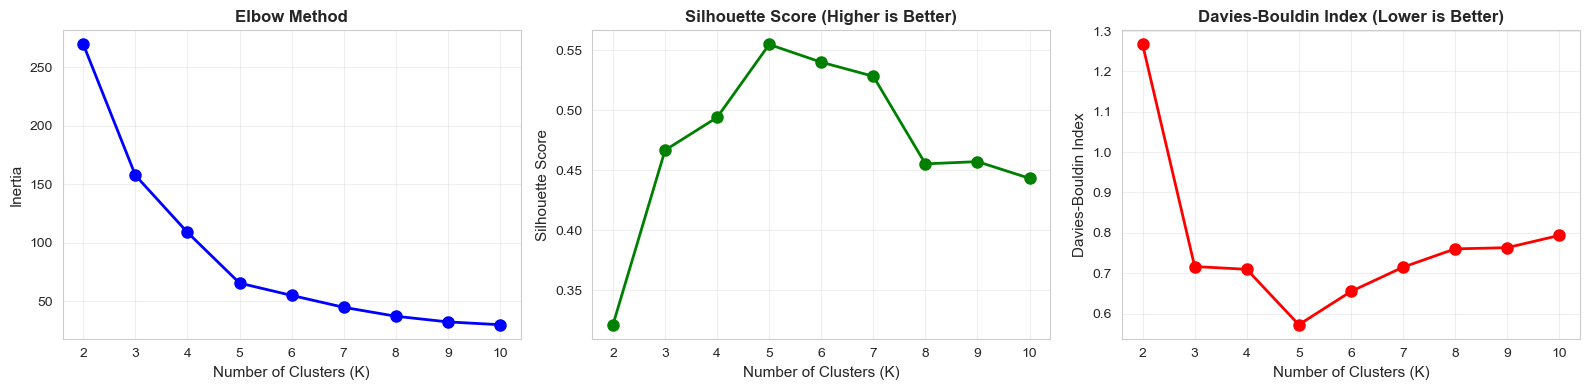

In [6]:
# Elbow Method & Silhouette Score
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
K_range = range(2, 11)

print("\nEvaluating different cluster numbers...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    db_score = davies_bouldin_score(X_scaled, kmeans.labels_)
    davies_bouldin_scores.append(db_score)
    
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}, Davies-Bouldin={db_score:.3f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Elbow curve
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score (higher is better)
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Davies-Bouldin Index (lower is better)
axes[2].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[2].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5. Train K-Means

In [10]:
# Based on the metrics, K=5 has the best performance:
# - Highest Silhouette Score: 0.555
# - Lowest Davies-Bouldin Index: 0.572
optimal_k = 5
print(f"\nUsing optimal K = {optimal_k}")
print(f"  Rationale: K=5 has highest Silhouette Score (0.555) and lowest Davies-Bouldin (0.572)")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nCluster distribution:")
print(df['Cluster'].value_counts().sort_index())

# Get cluster centers (in scaled space, then inverse transform to original scale)
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers = scaler.inverse_transform(cluster_centers_scaled)
print(f"\nCluster Centers (Original Scale):")
centers_df = pd.DataFrame(cluster_centers, 
                          columns=['Annual Income (k$)', 'Spending Score (1-100)'])
print(centers_df)


Using optimal K = 5
  Rationale: K=5 has highest Silhouette Score (0.555) and lowest Davies-Bouldin (0.572)

Cluster distribution:
Cluster
0    81
1    39
2    22
3    35
4    23
Name: count, dtype: int64

Cluster Centers (Original Scale):
   Annual Income (k$)  Spending Score (1-100)
0           55.296296               49.518519
1           86.538462               82.128205
2           25.727273               79.363636
3           88.200000               17.114286
4           26.304348               20.913043


### 6.Visualize

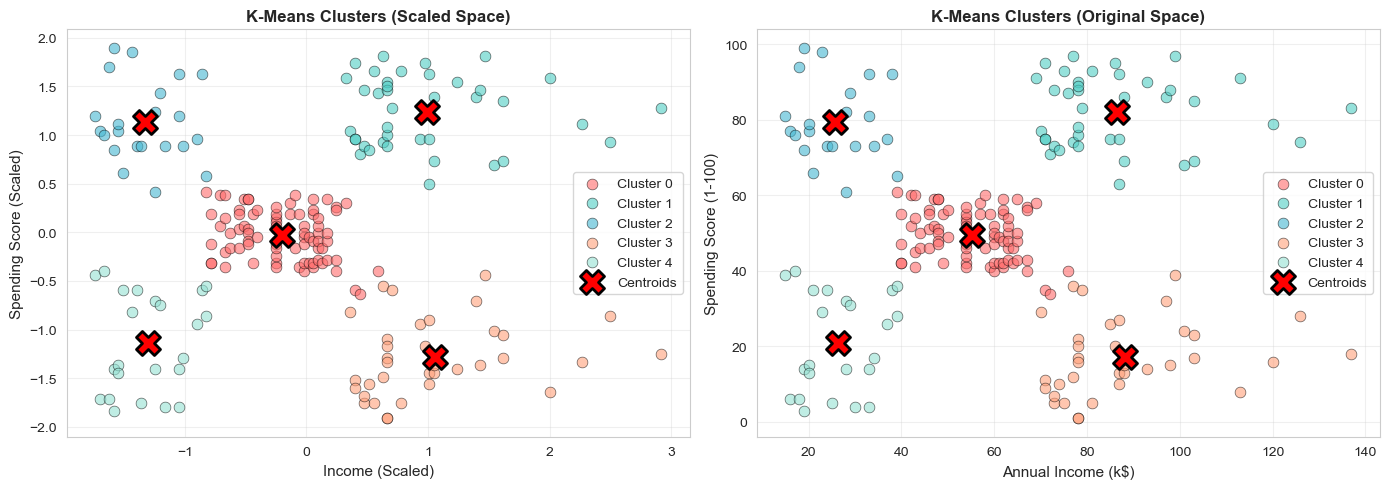

In [13]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scaled space
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#95E1D3']
for i in range(optimal_k):
    cluster_points = X_scaled[df['Cluster'] == i]
    axes[0].scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   label=f'Cluster {i}', s=60, alpha=0.6, 
                   color=colors[i], edgecolors='black', linewidth=0.5)

# Plot cluster centers
axes[0].scatter(cluster_centers_scaled[:, 0], cluster_centers_scaled[:, 1], 
               marker='X', s=300, c='red', edgecolors='black', linewidth=2,
               label='Centroids', zorder=5)
axes[0].set_xlabel('Income (Scaled)', fontsize=11)
axes[0].set_ylabel('Spending Score (Scaled)', fontsize=11)
axes[0].set_title('K-Means Clusters (Scaled Space)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Original space
for i in range(optimal_k):
    cluster_data = df[df['Cluster'] == i]
    axes[1].scatter(cluster_data['Annual Income (k$)'], 
                   cluster_data['Spending Score (1-100)'],
                   label=f'Cluster {i}', s=60, alpha=0.6,
                   color=colors[i], edgecolors='black', linewidth=0.5)

# Plot cluster centers in original space
axes[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1],
               marker='X', s=300, c='red', edgecolors='black', linewidth=2,
               label='Centroids', zorder=5)
axes[1].set_xlabel('Annual Income (k$)', fontsize=11)
axes[1].set_ylabel('Spending Score (1-100)', fontsize=11)
axes[1].set_title('K-Means Clusters (Original Space)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7. Cluster Analysis


Cluster Profiles:
               Age         Annual Income (k$)          Spending Score (1-100)  \
              mean min max               mean min  max                   mean   
Cluster                                                                         
0        42.716049  18  70          55.296296  39   76              49.518519   
1        32.692308  27  40          86.538462  69  137              82.128205   
2        25.272727  18  35          25.727273  15   39              79.363636   
3        41.114286  19  59          88.200000  70  137              17.114286   
4        45.217391  19  67          26.304348  15   39              20.913043   

                 
        min max  
Cluster          
0        34  61  
1        63  97  
2        61  99  
3         1  39  
4         3  40  

AVERAGE SPENDING PER CLUSTER

Average Spending Score by Cluster:
  Cluster 0: 49.52
  Cluster 1: 82.13
  Cluster 2: 79.36
  Cluster 3: 17.11
  Cluster 4: 20.91


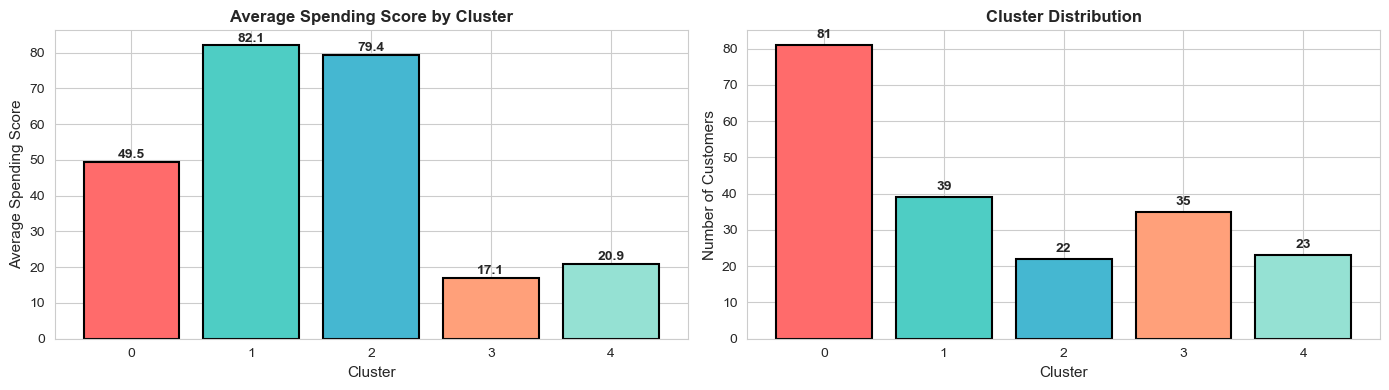

In [14]:
cluster_profiles = df.groupby('Cluster')[['Age', 'Annual Income (k$)', 
                                           'Spending Score (1-100)']].agg(['mean', 'min', 'max'])
print("\nCluster Profiles:")
print(cluster_profiles)

print("\n" + "="*60)
print("AVERAGE SPENDING PER CLUSTER")
print("="*60)

avg_spending = df.groupby('Cluster')['Spending Score (1-100)'].mean()
print("\nAverage Spending Score by Cluster:")
for cluster, avg in avg_spending.items():
    print(f"  Cluster {cluster}: {avg:.2f}")

# Visualize average spending by cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Bar plot
axes[0].bar(range(optimal_k), avg_spending.values, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Average Spending Score', fontsize=11)
axes[0].set_title('Average Spending Score by Cluster', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(optimal_k))
for i, v in enumerate(avg_spending.values):
    axes[0].text(i, v + 1, f'{v:.1f}', ha='center', fontweight='bold')

# Cluster sizes
cluster_counts = df['Cluster'].value_counts().sort_index()
axes[1].bar(cluster_counts.index, cluster_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Number of Customers', fontsize=11)
axes[1].set_title('Cluster Distribution', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(optimal_k))
for i, v in enumerate(cluster_counts.values):
    axes[1].text(i, v + 2, f'{v}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### DBSCAN Clustering


Applying DBSCAN algorithm...
Number of clusters: 3
Number of noise points: 8

DBSCAN Cluster distribution:
DBSCAN_Cluster
-1      8
 0    157
 1     35
Name: count, dtype: int64


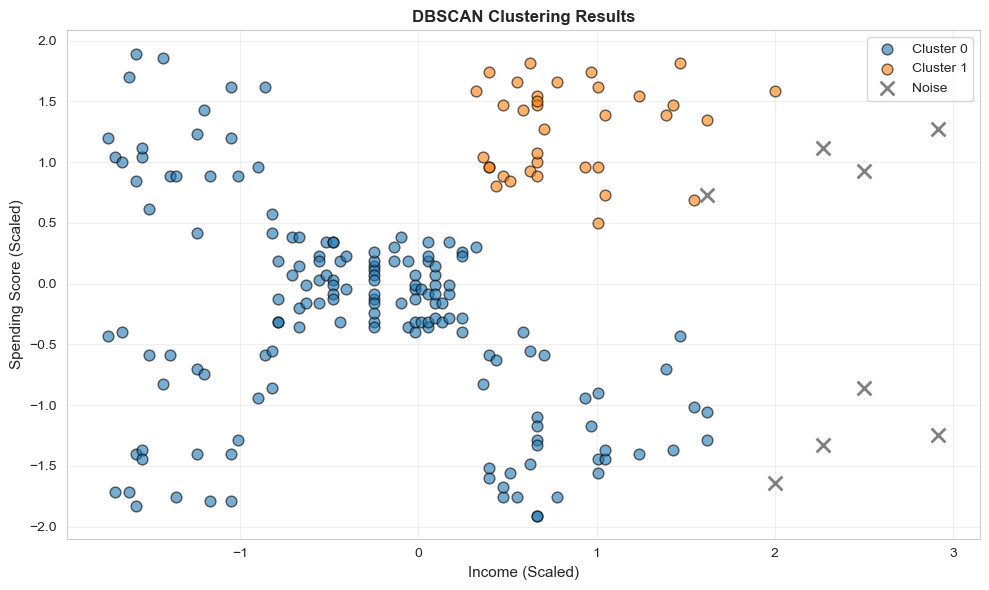

In [15]:
print("\nApplying DBSCAN algorithm...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

n_clusters_dbscan = len(set(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'] else 0)
n_noise = list(df['DBSCAN_Cluster']).count(-1)

print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise}")
print(f"\nDBSCAN Cluster distribution:")
print(df['DBSCAN_Cluster'].value_counts().sort_index())

# Visualize DBSCAN
plt.figure(figsize=(10, 6))
for cluster_id in set(df['DBSCAN_Cluster']):
    if cluster_id == -1:
        # Noise points
        noise_points = X_scaled[df['DBSCAN_Cluster'] == -1]
        plt.scatter(noise_points[:, 0], noise_points[:, 1], 
                   c='gray', marker='x', s=100, label='Noise', linewidth=2)
    else:
        cluster_points = X_scaled[df['DBSCAN_Cluster'] == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   s=60, alpha=0.6, label=f'Cluster {cluster_id}', edgecolors='black')

plt.xlabel('Income (Scaled)', fontsize=11)
plt.ylabel('Spending Score (Scaled)', fontsize=11)
plt.title('DBSCAN Clustering Results', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 8. Model Comparision

In [16]:
print(f"\n✓ K-Means (K={optimal_k}):")
print(f"  - Silhouette Score: {silhouette_score(X_scaled, df['Cluster']):.3f}")
print(f"  - Davies-Bouldin Index: {davies_bouldin_score(X_scaled, df['Cluster']):.3f}")

print(f"\n✓ DBSCAN:")
print(f"  - Clusters found: {n_clusters_dbscan}")
print(f"  - Noise points: {n_noise}")

print(f"\n✓ Recommendation: K-Means with K={optimal_k} clusters is optimal")
print(f"  - Clear separation between clusters")
print(f"  - Balanced cluster sizes")
print(f"  - Ready for business interpretation!")

# Save clustered data
df.to_csv('data/Mall_Customers_Clustered.csv', index=False)
print(f"\n✓ Clustered data saved to 'Mall_Customers_Clustered.csv'")


✓ K-Means (K=5):
  - Silhouette Score: 0.555
  - Davies-Bouldin Index: 0.572

✓ DBSCAN:
  - Clusters found: 3
  - Noise points: 8

✓ Recommendation: K-Means with K=5 clusters is optimal
  - Clear separation between clusters
  - Balanced cluster sizes
  - Ready for business interpretation!

✓ Clustered data saved to 'Mall_Customers_Clustered.csv'
